# pythia-features

In [99]:
import os
from importlib import reload
from itertools import product
from typing import Tuple, List, Dict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from utils import utils, stats

In [100]:
# Knobs
data_paths: Dict[Tuple[str, ...], str] = {
    ('PC', 'PC_Delta'): ('/u/cmolder/GitHub/Pythia/out/'
                         'pythia_level/exp_394r/exp_394r_features.csv'),
    ('Delta_Path', 'PC_Delta'): ('/u/cmolder/GitHub/Pythia/out/'
                                 'pythia_level/exp_394r/exp_394r_features.csv'),
}
output_dir: str = './plots/pythia_features'
suites: List[List[str]] = [utils.spec06, utils.spec17, utils.gap]
suite_names: List[str] = ['SPEC 06', 'SPEC 17', 'GAP']
metrics: List[str] = ['ipc_improvement', 'LLC_mpki_reduction', 
                       'L2C_mpki_reduction']

dpi = 120

In [101]:
def load_data(data_paths: Dict[Tuple[str, ...], str]) \
    -> Dict[Tuple[str, ...], pd.DataFrame]:
    """Load different feature groupings, as stored in a 
    .csv file generated from the evaluate script in 
    Pythia/experiments.
    """
    data_df = {}
    for features in data_paths.keys():
        df = utils.read_data_file(data_paths[features])
        #df = df[df.seed == seed]
        df = df[df.pythia_features == str(features)]
        data_df[features] = df
    
data_df : dict = load_data(data_paths)

---
## Metrics of each static threshold
- How does each static threshold compare to regular Pythia, and no prefetcher?

In [97]:
def plot_metric(dfs: dict, metric: str, 
                dpi: int = None, 
                figsize: Tuple[int, int] = None,
                suite_name: str= None) -> None:
    """Plot the metric between the dfs on each trace
    in a suite.
    """
    match_pref = lambda x : x == ('no', 'pythia', 'no') # Used in p_samples
    
    fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
    num_samples = len(dfs.items())
    gap = num_samples + 1

    traces = list(list(dfs.values())[0].trace.unique()) + ['mean']
    trace_names = (list(list(dfs.values())[0].trace.unique()) 
                   + (['amean'] if metric in utils.amean_metrics 
                                else ['gmean']))
    largest_y = 0
    for i, (setup, df) in enumerate(dfs.items()):
        df = df[df.pythia_level_threshold == float('-inf')]
        df = stats.add_means(df) # Add mean as an extra trace

        for j, tr in enumerate(traces):
            rows = df[df.trace == tr]
            pos = gap*j + i
            #print(f'[DEBUG] i={i} j={j} setup={setup} tr={tr} pos={pos}, {pos+1}')
            p_samples = (rows[rows.all_pref.apply(match_pref)]
                             [metric])
            p_min, p_mean, p_max = (p_samples.min(), p_samples.mean(), 
                                    p_samples.max())
            
            largest_y = max(largest_y, p_max)
            
            #print(f'[DEBUG] {tr} Regular {setup} {p_mean:.2f} {p_min:.2f} {p_max:.2f}')
            ax.bar(
                pos, p_mean, 
                label=f'{setup}' if j == 0 else None, 
                color=f'C{i}'
            )
            ax.errorbar(
                pos, p_mean, 
                yerr= [[p_mean - p_min], [p_max - p_mean]], 
                color='black'
            )

    ax.set_xticks(
        np.arange(0, len(df.trace.unique())) * gap + (num_samples/2)
    )
    ax.set_xticklabels(trace_names, rotation=90)
    ax.set_xlabel('Trace')

    ax.set_yticks(np.arange(0, round(largest_y, -1) + 10, 10))
    ax.set_ylabel(metric.replace('_', ' ') + ' (%)')
    ax.grid(axis='y', color='lightgray')
    ax.set_axisbelow(True)
        
    #fig.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    fig.legend()
    fig.suptitle(f'{metric.replace("_", " ")} ({suite_name})') \
                 if suite_name is not None \
                 else fig.suptitle(f'{metric.replace("_", " ")}')
    fig.tight_layout()

---
# Different features

In [77]:
os.makedirs(f'{output_dir}/', exist_ok=True)
# os.makedirs(f'{output_dir}/ipc_improvement', exist_ok=True)
# os.makedirs(f'{output_dir}/L2C_mpki_reduction', exist_ok=True)
# os.makedirs(f'{output_dir}/LLC_mpki_reduction', exist_ok=True)

SPEC '06
SPEC '17
GAP


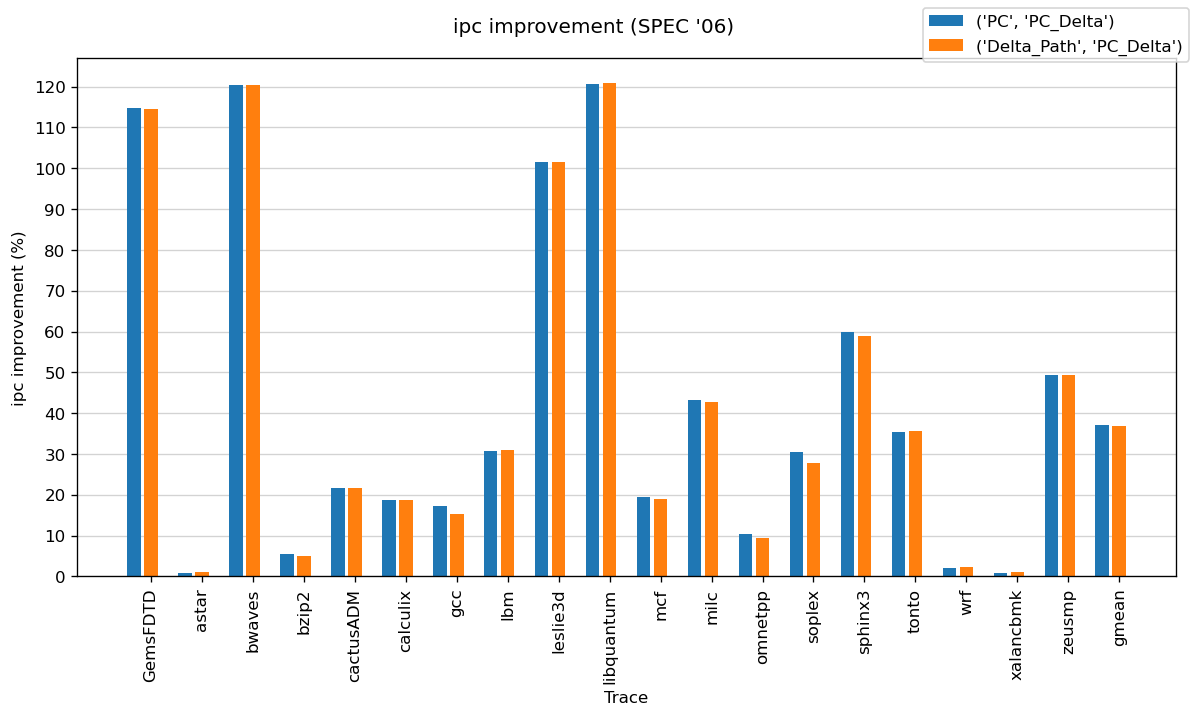

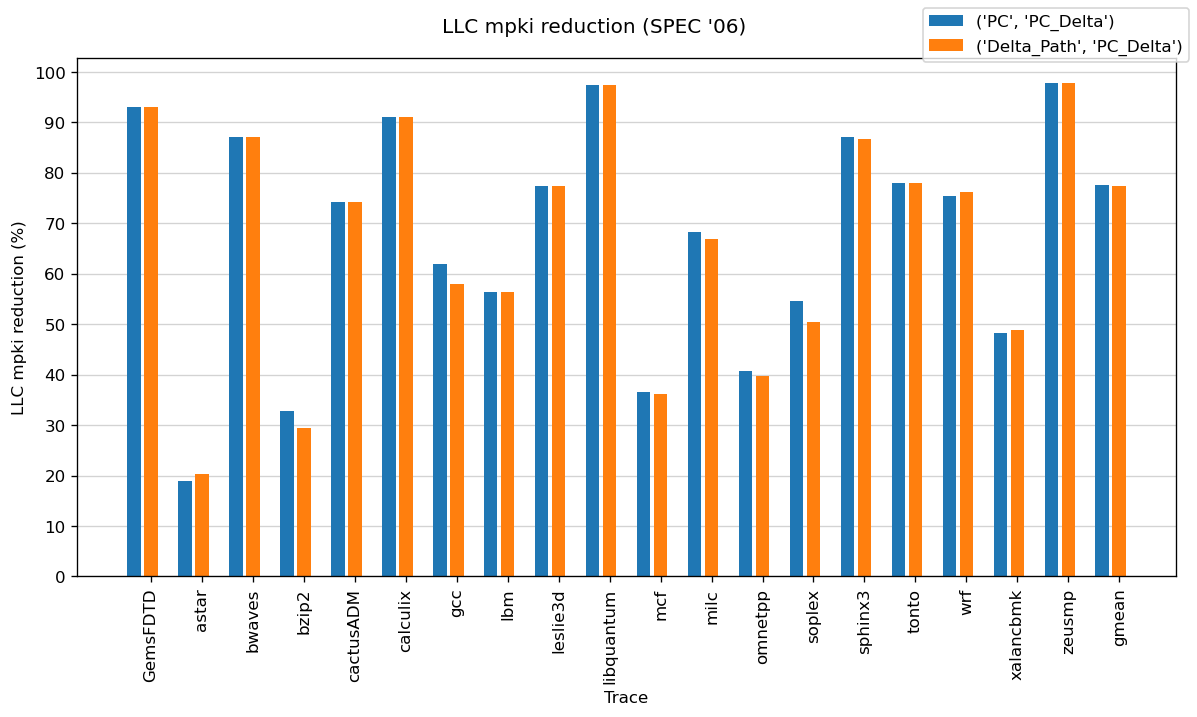

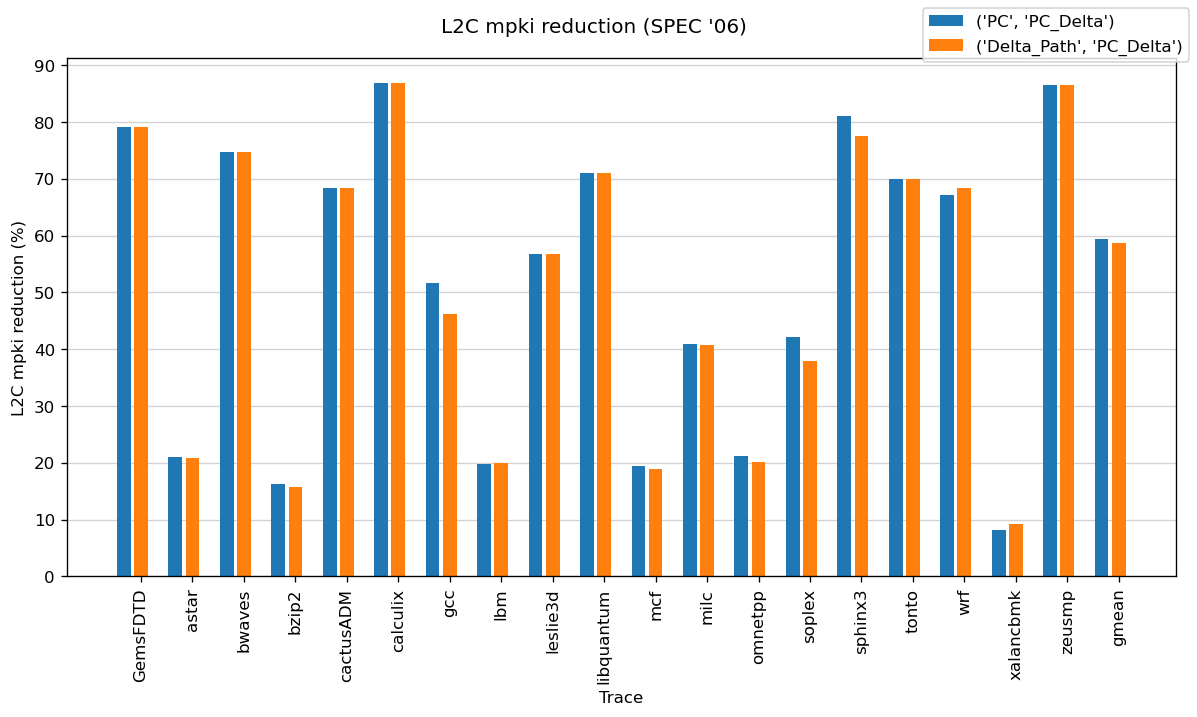

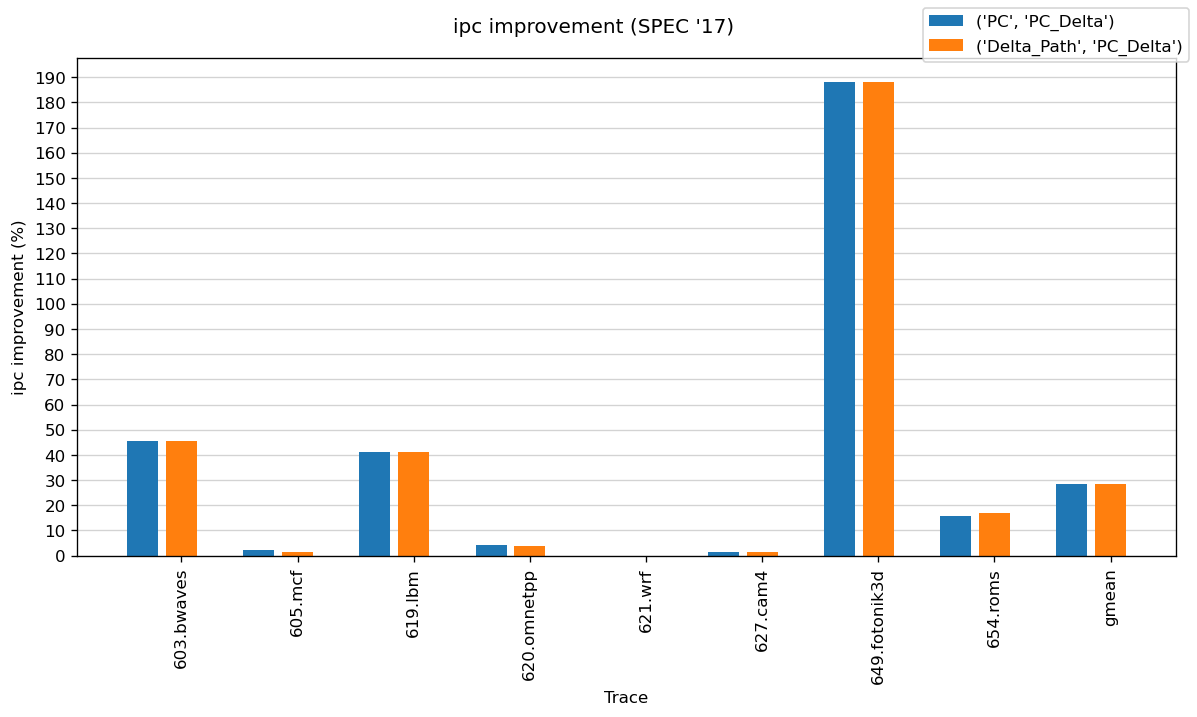

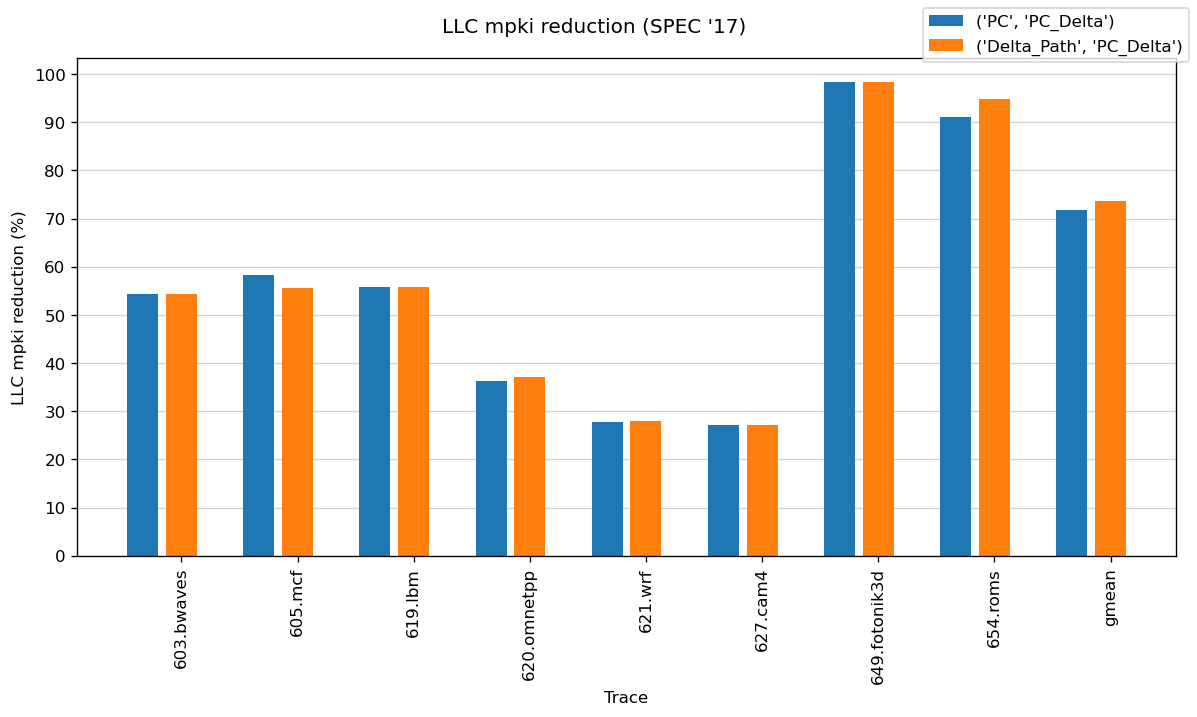

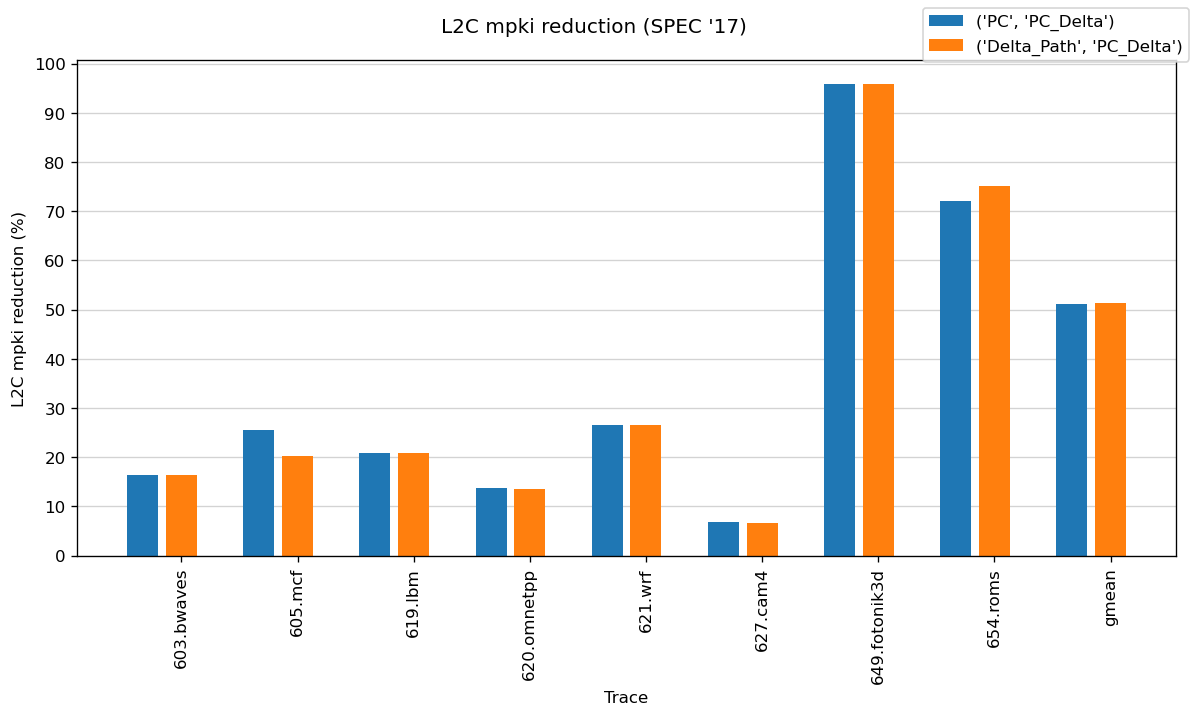

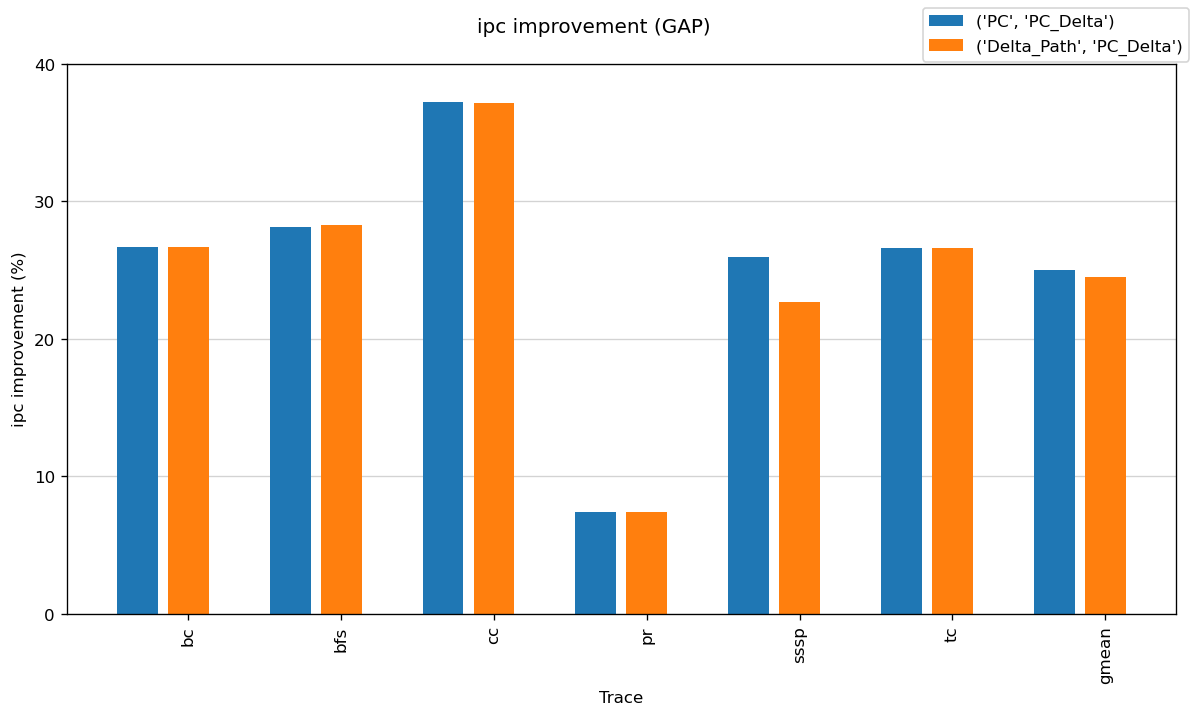

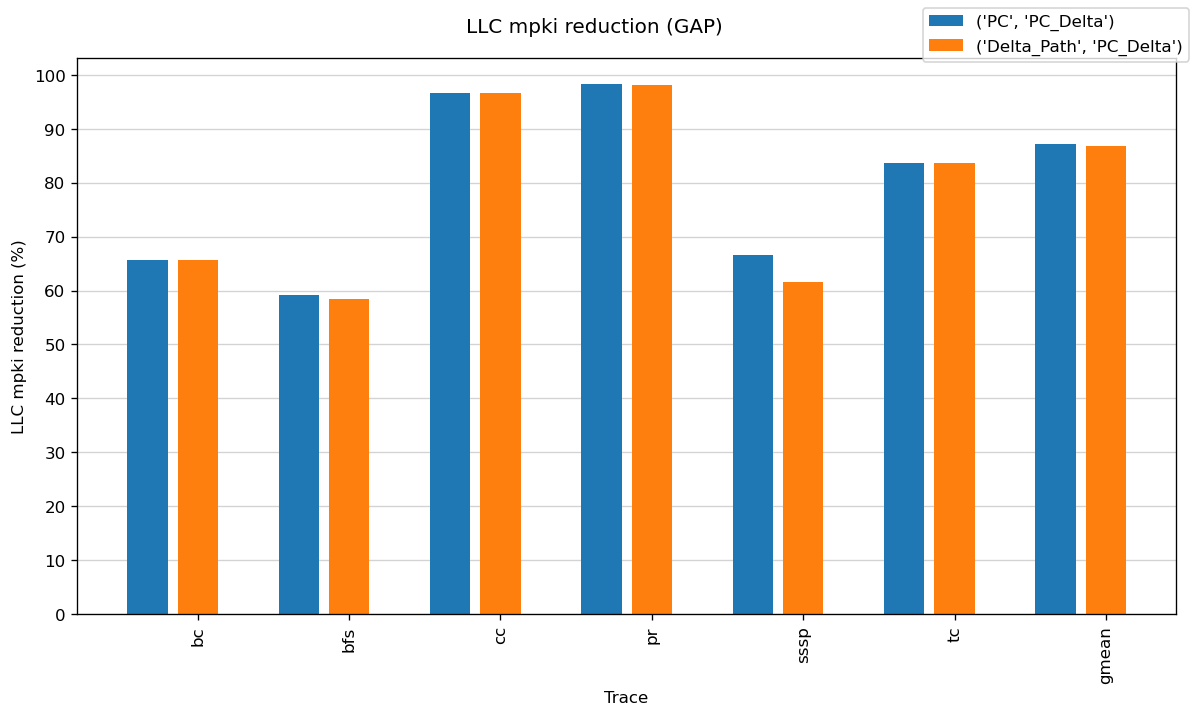

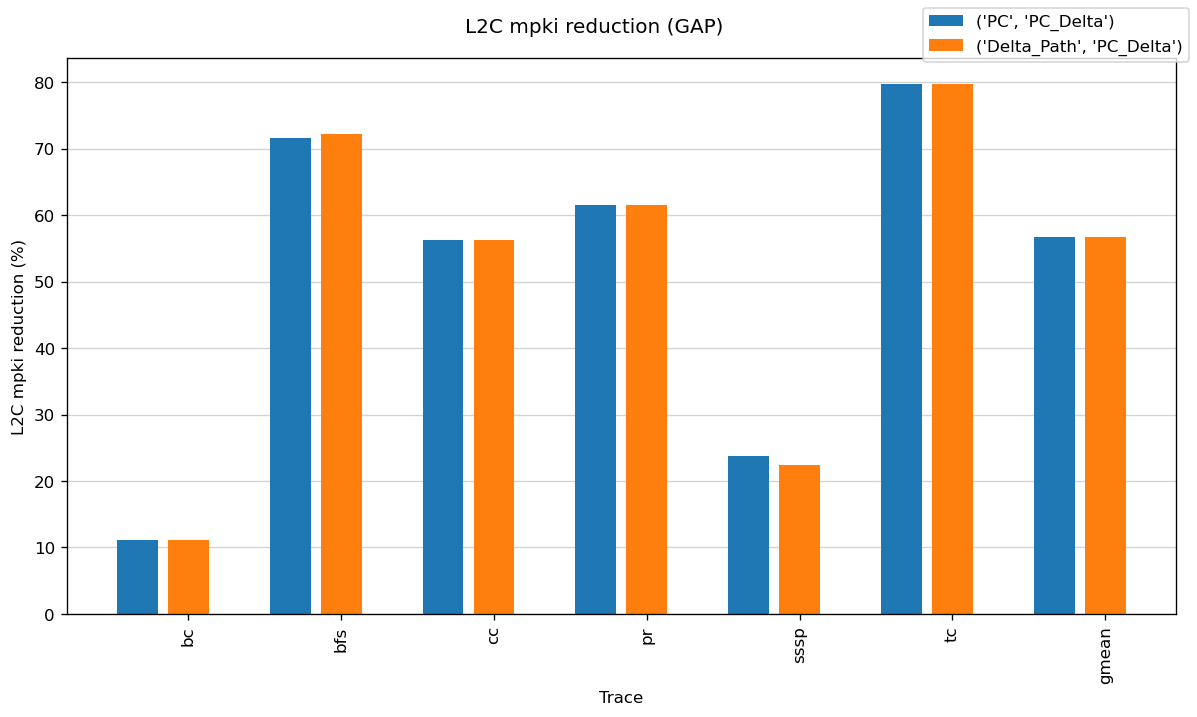

In [82]:
for suite_name, suite in zip(suite_names, suites):
    data_df_ = {k : v[v.trace.isin(suite)] for k,v in data_df.items()}
    
    print(suite_name)
    for metric in metrics: 
        plot_metric(
            data_df_, metric,
            suite_name=suite_name,
            figsize=(10,6),
            dpi=dpi
        )
        plt.savefig(
            f'{output_dir}/{suite_name}_{metric}.pdf', 
            bbox_inches='tight'
        )